## Lets Voronoi Baby

#### Sources:
- https://towardsdatascience.com/how-to-create-voronoi-regions-with-geospatial-data-in-python-adbb6c5f2134
- https://pypi.org/project/geovoronoi/

#### Get the libs for this project:

In [48]:
import numpy as np
import pandas as pd
import geopandas as gpd

import matplotlib.pyplot as plt
from shapely.ops import unary_union
from geovoronoi import voronoi_regions_from_coords, points_to_coords
from geovoronoi.plotting import subplot_for_map, plot_voronoi_polys_with_points_in_area

from shapely.geometry import box, Polygon, LineString, Point

import pyproj
from shapely.ops import transform



#### Load Files

In [14]:
# pandas data frame from cites in a csv
df1 = pd.read_csv("data/cities.csv")

# geopandas data frame from a geojson file
gdf2 = gpd.read_file("data/cities_small.json")

We need to convert the lat/lon columns to a `geometry` data type. A `Point` to be more specific. Using our csv file and the dataframe (`df1`), we create a `geodataframe` (`gdf1`) using the coordinates in `df1`

In [15]:
gdf1 = gpd.GeoDataFrame(df1, geometry=gpd.points_from_xy(df1.lon, df1.lat))
gdf1.head()

,city,growth,lat,lon,population,rank,state,geometry
0,New York,4.8,40.712784,-74.005941,8405837,1,New York,POINT (-74.00594 40.71278)
1,Los Angeles,4.8,34.052234,-118.243685,3884307,2,California,POINT (-118.24368 34.05223)
2,Chicago,-6.1,41.878114,-87.629798,2718782,3,Illinois,POINT (-87.62980 41.87811)
3,Houston,11.0,29.760427,-95.369803,2195914,4,Texas,POINT (-95.36980 29.76043)
4,Philadelphia,2.6,39.952584,-75.165222,1553165,5,Pennsylvania,POINT (-75.16522 39.95258)


However! Reading in the geojson file already has the correct `Point` `geometry` done for us! So from here on down, we could use either `gdf1` or `gdf2`

In [16]:
gdf2.head()

,city,growth,population,rank,state,marker-color,marker-size,geometry
0,Portland,15.0,609456,29,Oregon,#879CB9,medium,POINT (-122.67648 45.52306)
1,Seattle,15.6,652405,21,Washington,#14F334,medium,POINT (-122.33207 47.60621)
2,Los Angeles,4.8,3884307,2,California,#5F2B67,medium,POINT (-118.24368 34.05223)
3,Boise City,9.5,214237,98,Idaho,#94EEF1,medium,POINT (-116.21461 43.61871)
4,Las Vegas,24.5,603488,30,Nevada,#F3E40F,medium,POINT (-115.13983 36.16994)


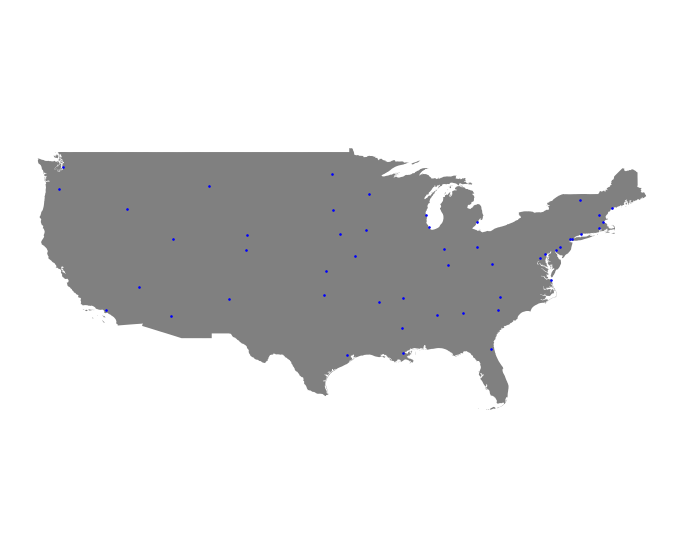

In [17]:

#boundary = gpd.read_file("data/us_nation_border.geojson")
boundary = gpd.read_file("data/us_border_shp/us_border.shp")
fig, ax = plt.subplots(figsize=(12, 10))
boundary.plot(ax=ax, color="gray")
gdf2.plot(ax=ax, markersize=2.5, color="blue")
ax.axis("off")
plt.axis('equal')

# minx, miny, maxx, maxy = gdf2.total_bounds
# print(minx,miny,maxx,maxy)
# ax.set_xlim(minx-5, maxx+5)
# ax.set_ylim(miny, maxy)
plt.show()

Must ensure that the coords are of the correct "projection" type. 

In [43]:
boundary = boundary.to_crs(epsg=3395)
gdf_proj = gdf2.to_crs(boundary.crs)
print("="*40)
boundary.crs


<Projected CRS: EPSG:3395>
Name: WGS 84 / World Mercator
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: World between 80°S and 84°N.
- bounds: (-180.0, -80.0, 180.0, 84.0)
Coordinate Operation:
- name: World Mercator
- method: Mercator (variant A)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

Convert the "points" to "coords". See the values after the cell to see the difference!

In [19]:
boundary_shape = unary_union(boundary.geometry)

coords = points_to_coords(gdf_proj.geometry)

coords
 

array([[-13656283.50855019,   5673745.36396603],
       [-13617943.85140659,   6010018.39568719],
       [-13162826.80372024,   4011892.6892015 ],
       [-12936950.8739804 ,   5377138.44952307],
       [-12817307.24562408,   4298811.23593637],
       [-12476024.7299865 ,   3931420.55464436],
       [-12455654.37636624,   4949216.42651617],
       [-12078241.56151883,   5715051.523275  ],
       [-11867275.87569534,   4150923.18763879],
       [-11687461.27957798,   4800799.48308428],
       [-11668536.40954567,   5004892.78901347],
       [-10855479.10893892,   4202810.00011476],
       [-10835406.31231755,   4509442.97393323],
       [-10774591.58394126,   5890848.95234786],
       [-10768057.1298317 ,   5365789.27343607],
       [-10686447.14133879,   5021455.49519044],
       [-10616517.90701482,   3451586.29002094],
       [-10528437.91839751,   4709014.52364948],
       [-10420518.01353357,   5072953.22679703],
       [-10382213.53334906,   5587806.02802277],
       [-10273630.72

Create the Voronoi diagram...

In [20]:
region_polys, region_pts = voronoi_regions_from_coords(coords, boundary_shape)

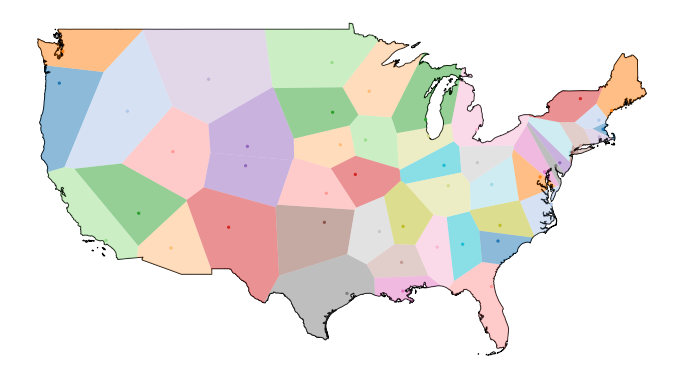

In [21]:
fig, ax = subplot_for_map(figsize=(12, 10))
# gdf1.plot(ax=ax, markersize=2.5, color="blue")
plot_voronoi_polys_with_points_in_area(ax, boundary_shape, region_polys, coords, region_pts)
plt.show()

Traverse the "polygons" created. We could now turn those into a "feature list" to display on `geojson.io` or load each polygon into a spatial index to run queries with them (like find UFO's that are in each polygon). 

In [53]:
# for i,poly in region_polys.items():
#     if i == 0:
#         continue
#     print(poly)
print(len(region_polys))
print(region_polys)


49
{0: <shapely.geometry.polygon.Polygon object at 0x7fd34101e670>, 1: <shapely.geometry.polygon.Polygon object at 0x7fd34101e4c0>, 2: <shapely.geometry.polygon.Polygon object at 0x7fd34101eeb0>, 3: <shapely.geometry.polygon.Polygon object at 0x7fd34101ecd0>, 4: <shapely.geometry.polygon.Polygon object at 0x7fd34101e370>, 5: <shapely.geometry.polygon.Polygon object at 0x7fd34101ed90>, 6: <shapely.geometry.polygon.Polygon object at 0x7fd34101e7f0>, 7: <shapely.geometry.polygon.Polygon object at 0x7fd34101e1f0>, 8: <shapely.geometry.polygon.Polygon object at 0x7fd34101e430>, 9: <shapely.geometry.polygon.Polygon object at 0x7fd34101ef40>, 10: <shapely.geometry.polygon.Polygon object at 0x7fd34101e8e0>, 11: <shapely.geometry.polygon.Polygon object at 0x7fd34101e7c0>, 12: <shapely.geometry.polygon.Polygon object at 0x7fd34101ef10>, 13: <shapely.geometry.polygon.Polygon object at 0x7fd34101e490>, 14: <shapely.geometry.polygon.Polygon object at 0x7fd34101e9a0>, 15: <shapely.geometry.polygon.P

In [76]:

ufoDF = pd.read_csv("data/BetterUFOData.csv")

#ufoDF.to_crs(epsg=3395)

ufoGDF = gpd.GeoDataFrame(ufoDF, geometry=gpd.points_from_xy(ufoDF.lon, ufoDF.lat))

#ufoGDF.crs = "EPSG:4326"

ufoGDF.set_crs(epsg=3395, inplace=True)

ufoGDF.head()



,city,state,shape,duration,date_time,lon,lat,geometry
0,Visalia,CA,light,2 minutes,2021-12-15T21:45:00,-119.347937,36.356650,POINT (-119.348 36.357)
1,Cincinnati,OH,triangle,14 seconds,2021-12-16T09:45:00,-84.481363,39.174503,POINT (-84.481 39.175)
2,Knoxville,TN,triangle,20-30 seconds,2021-12-10T19:30:00,-83.980115,35.961561,POINT (-83.980 35.962)
3,Fullerton,CA,unknown,2 minutes,2020-07-07T23:00:00,-117.924978,33.877422,POINT (-117.925 33.877)
4,Las Vegas,NV,oval,10 minutes,2020-04-23T03:00:00,-115.186592,36.141246,POINT (-115.187 36.141)


In [89]:

#print(list(region_polys.values()))
s = gpd.GeoSeries(ufoGDF['geometry'])

# loop through each of voronio's polygons finding the 
# UFO's that are within that polygon
for i,poly in region_polys.items():
    res = s.within(poly)
    
    for r in res:
        print(r)
       
    break

False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
Fals

KeyboardInterrupt: 